In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
import glob
from matplotlib.dates import DateFormatter


cys


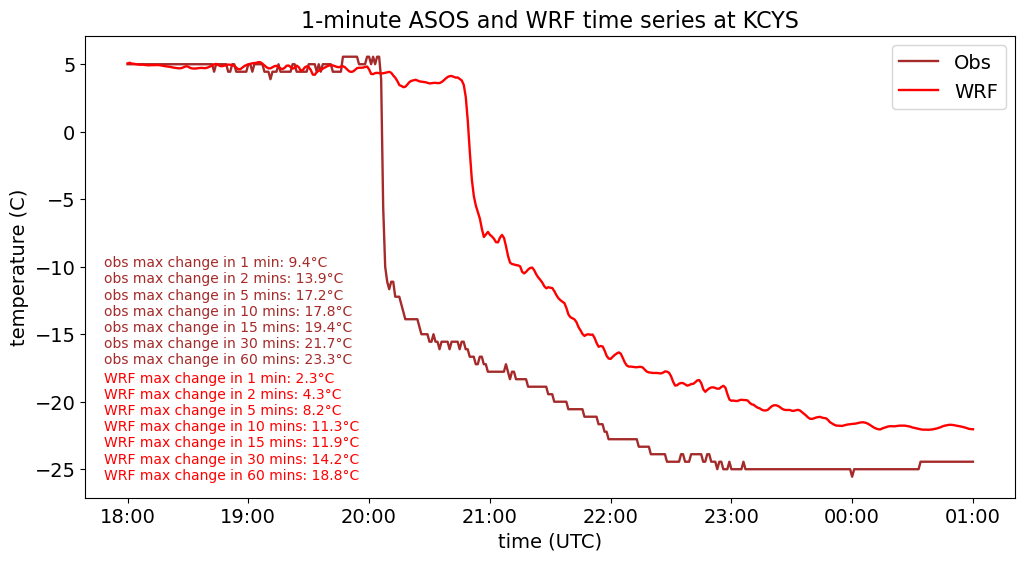

In [4]:
###### get list of stations and loop over them:
### get list of WRF TS files
#tslist = glob.glob("tser/*.d02.TS")
#asos_stns = ["ako","den","cys","lic"]
asos_stns = ['cys']

### WRF init time
init=pd.Timestamp(2022,12,21,18)
end = pd.Timestamp(2022,12,22,5)
timestep = 3  ### in seconds

for loc in asos_stns:
    
    #loc = tsfile.split("/")[1].split(".")[0].lower()  ### should be the station ID
    print(loc)
    
    try:

        data = pd.read_fwf("tser/"+loc+".d02.TS", skiprows=1, header=None, infer_nrows=50000)
        #data = pd.read_fwf("/glade/scratch/rschumac/WRFV4/run/thomps_3dom_noah/sedg.d03.TS", skiprows=1, header=None)

        data.columns=['domain','time','tsid','ix','iy','t2k','qv','u10','v10','psfc','glw','gsw','hfx','lh','tsk','tslb','rainc','rainnc','clw']

        data['wspd'] = (data['u10']**2+data['v10']**2)**(0.5)
        data['t2c'] = data['t2k'] - 273.15

        #data['datetime'] = (init + pd.TimedeltaIndex(data['time'], unit='H')).tz_localize("UTC")
        ### or because the timestamps in the file get rounded off which causes problems, just set it to the right frequency:
        timestep_str = str(timestep)+"S"
        data['datetime'] = pd.date_range((init+pd.Timedelta(seconds=timestep)),end,freq=timestep_str).tz_localize("UTC")

        data.set_index('datetime', inplace=True)

        ### subset down in time
        data = data['2022-12-21 18:00':'2022-12-22 01:00']

        ### optional - subsample the WRF output to match the observations
        data = data.asfreq('1min')

        ### set a multi-index to allow for stacking/unstacking
        data.set_index([data.index,"domain"],inplace=True)

        ### calculate shifts

        ### note that timesteps don't exactly match up at 10 and 20 minutes; use the fractions of hours instead
        data['shifted_1min'] = data.unstack().shift(1, freq='min').stack()['t2k']
        data['shifted_2min'] = data.unstack().shift(2, freq='min').stack()['t2k']
        data['shifted_5min'] = data.unstack().shift(5, freq='min').stack()['t2k']
        data['shifted_10min'] = data.unstack().shift(10, freq='min').stack()['t2k']
        data['shifted_15min'] = data.unstack().shift(15, freq='min').stack()['t2k']
        data['shifted_20min'] = data.unstack().shift(20, freq='min').stack()['t2k']
        data['shifted_30min'] = data.unstack().shift(30, freq='min').stack()['t2k']
        data['shifted_60min'] = data.unstack().shift(60, freq='min').stack()['t2k']
        data['shifted_120min'] = data.unstack().shift(120, freq='min').stack()['t2k']
        data['shifted_180min'] = data.unstack().shift(180, freq='min').stack()['t2k']

        data['Tchange_1min'] = data['shifted_1min'] - data['t2k']
        data['Tchange_2min'] = data['shifted_2min'] - data['t2k']
        data['Tchange_5min'] = data['shifted_5min'] - data['t2k']
        data['Tchange_10min'] = data['shifted_10min'] - data['t2k']
        data['Tchange_15min'] = data['shifted_15min'] - data['t2k']
        data['Tchange_20min'] = data['shifted_20min'] - data['t2k']
        data['Tchange_30min'] = data['shifted_30min'] - data['t2k']
        data['Tchange_60min'] = data['shifted_60min'] - data['t2k']
        data['Tchange_120min'] = data['shifted_120min'] - data['t2k']
        data['Tchange_180min'] = data['shifted_180min'] - data['t2k']

        ### and reset index
        data = data.reset_index().set_index('datetime')

        ### now get ASOS data from IEM
        asos = pd.read_csv("https://mesonet.agron.iastate.edu/cgi-bin/request/asos1min.py?station="+loc.upper()+"&tz=UTC&year1=2022&month1=12&day1=21&hour1=0&minute1=0&year2=2022&month2=12&day2=24&hour2=0&minute2=0&vars=tmpf&vars=pres1&sample=1min&what=download&delim=comma&gis=yes",
                          parse_dates=['valid(UTC)'])

        asos['datetime'] = asos['valid(UTC)'].dt.tz_localize("UTC")
        asos.set_index("datetime", inplace=True)

        ### F to C
        #asos['tmpc'] = (asos['tmpf']-32.)/1.8
        asos['tmpc'] = (pd.to_numeric(asos['tmpf'], errors='coerce')-32.)/1.8

        ### subset down to same time as the WRF output
        asos = asos['2022-12-21 18:00':'2022-12-22 01:00'] 

        ### set a multi-index to allow for stacking/unstacking
        asos.set_index([asos.index,"station"],inplace=True)

        ### calculate shifts
        asos['shifted_1min'] = asos.unstack().shift(1, freq='min').stack()['tmpc']
        asos['shifted_2min'] = asos.unstack().shift(2, freq='min').stack()['tmpc']
        asos['shifted_5min'] = asos.unstack().shift(5, freq='min').stack()['tmpc']
        asos['shifted_10min'] = asos.unstack().shift(10, freq='min').stack()['tmpc']
        asos['shifted_15min'] = asos.unstack().shift(15, freq='min').stack()['tmpc']
        asos['shifted_20min'] = asos.unstack().shift(20, freq='min').stack()['tmpc']
        asos['shifted_30min'] = asos.unstack().shift(30, freq='min').stack()['tmpc']
        asos['shifted_60min'] = asos.unstack().shift(60, freq='min').stack()['tmpc']
        asos['shifted_120min'] = asos.unstack().shift(120, freq='min').stack()['tmpc']
        asos['shifted_180min'] = asos.unstack().shift(180, freq='min').stack()['tmpc']

        asos['Tchange_1min'] = asos['shifted_1min'] - asos['tmpc']
        asos['Tchange_2min'] = asos['shifted_2min'] - asos['tmpc']
        asos['Tchange_5min'] = asos['shifted_5min'] - asos['tmpc']
        asos['Tchange_10min'] = asos['shifted_10min'] - asos['tmpc']
        asos['Tchange_15min'] = asos['shifted_15min'] - asos['tmpc']
        asos['Tchange_20min'] = asos['shifted_20min'] - asos['tmpc']
        asos['Tchange_30min'] = asos['shifted_30min'] - asos['tmpc']
        asos['Tchange_60min'] = asos['shifted_60min'] - asos['tmpc']
        asos['Tchange_120min'] = asos['shifted_120min'] - asos['tmpc']
        asos['Tchange_180min'] = asos['shifted_180min'] - asos['tmpc']

        ### and reset index
        asos = asos.reset_index().set_index('datetime')

        ### and matplotlib plot

        fig, ax = plt.subplots(figsize=(12,6))

        ax.plot(asos.index,asos['tmpc'], label='Obs', color='brown', lw=1.7)
        ax.plot(data.index,data['t2c'], label='WRF', color='red', lw=1.7)

        ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))
        ax.set_xlabel("time (UTC)", fontsize=14)
        ax.set_ylabel("temperature (C)", fontsize=14)
        ax.tick_params(axis='both', labelsize=14)

        plt.title("1-minute ASOS and WRF time series at K"+loc.upper(), fontsize=16)
        ax.legend(fontsize=14)

        ### add text annotation with the largest temperature drops
        ax.text(0.02,0.29,"obs max change in 1 min: "+str(np.round(asos['Tchange_1min'].max(),1))+"°C\nobs max change in 2 mins: "+str(np.round(asos['Tchange_2min'].max(),1))+"°C\nobs max change in 5 mins: "+str(np.round(asos['Tchange_5min'].max(),1))+"°C\nobs max change in 10 mins: "+str(np.round(asos['Tchange_10min'].max(),1))+"°C\nobs max change in 15 mins: "+str(np.round(asos['Tchange_15min'].max(),1))+"°C\nobs max change in 30 mins: "+str(np.round(asos['Tchange_30min'].max(),1))+"°C\nobs max change in 60 mins: "+str(np.round(asos['Tchange_60min'].max(),1))+"°C",
                color='brown',fontsize=10,
               transform=ax.transAxes)
        ### add text annotation with the largest temperature drops
        ax.text(0.02,0.04,"WRF max change in 1 min: "+str(np.round(data['Tchange_1min'].max(),1))+"°C\nWRF max change in 2 mins: "+str(np.round(data['Tchange_2min'].max(),1))+"°C\nWRF max change in 5 mins: "+str(np.round(data['Tchange_5min'].max(),1))+"°C\nWRF max change in 10 mins: "+str(np.round(data['Tchange_10min'].max(),1))+"°C\nWRF max change in 15 mins: "+str(np.round(data['Tchange_15min'].max(),1))+"°C\nWRF max change in 30 mins: "+str(np.round(data['Tchange_30min'].max(),1))+"°C\nWRF max change in 60 mins: "+str(np.round(data['Tchange_60min'].max(),1))+"°C",
                color='red',fontsize=10,
               transform=ax.transAxes)

        fig.savefig("wrf_asos_tser_compare_"+loc+".pdf", dpi=255, 
                    bbox_inches='tight', transparent=False, facecolor='white')

        plt.show()

        plt.close('all')

    except:
        print("plotting for "+loc+" failed")


